In [16]:
import pandas as pd
from tabulate import tabulate
from scipy.stats import ttest_ind
import warnings
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from sklearn.metrics import precision_recall_curve
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
pd.set_option('display.max_columns', None)

In [17]:
play2024_df = pd.read_csv("data/play_by_play_2024.csv")
injury2024_df = pd.read_csv("data/injuries_2024.csv")

In [18]:
def first_last_a(name):
    parts = name.split(" ", 1)
    return f"{parts[0][0]}.{parts[1]}"

In [19]:
def first_last_b(name):
    parts = name.split(" ", 1)
    return f"{parts[0][0:2]}.{parts[1]}"

In [20]:
warnings.filterwarnings('ignore')

def merge_play_injury_dfs(play_df, injury_df):

    # preprocessing
    injury_df["date"] = pd.to_datetime(injury_df['date_modified'])
    play_df["date"] = pd.to_datetime(play_df['game_date'])
    injury_df['date'] = injury_df['date'].dt.tz_localize(None)
    play_df['date'] = play_df['date'].dt.tz_localize(None)

    # filtering
    plays_with_injuries = play_df[play_df['desc'].str.contains("was injured", na=False)]
    pattern = r'(\w+\.(?:\w|-|\.|\')+(?: \w+)*) was injured'
    # Extract the injured player's name from the desc column
    injured_players = plays_with_injuries.loc[:, "desc"].str.extract(pattern)

    # concatenation
    plays_with_injuries = pd.concat([plays_with_injuries, injured_players], axis=1)
    plays_with_injuries.rename(columns={0: "injured_player"}, inplace=True)
    plays_with_injuries = plays_with_injuries.reset_index(drop=True)
    
    # merging
    injuries = []
    for (week, team), group_injury_df in injury_df.groupby(['week', 'team']):
        group_play_df = plays_with_injuries[(plays_with_injuries['week'] == week) & ((plays_with_injuries['home_team'] == team) | (plays_with_injuries['away_team'] == team))]

        group_injury_df = group_injury_df[group_injury_df.date >= group_play_df.date.max()]

        group_injury_df["first_type"] = group_injury_df['full_name'].apply(first_last_a)
        group_injury_df["second_type"] = group_injury_df['full_name'].apply(first_last_b)

        x = pd.merge(group_play_df, group_injury_df, left_on="injured_player", right_on="first_type", how="inner")
        y = pd.merge(group_play_df, group_injury_df, left_on="injured_player", right_on="second_type", how="inner")

        injuries.append(pd.concat([x, y], axis = 0, ignore_index=True))

    plays_with_injuries_and_injury_record = (pd.concat(injuries, axis=0, ignore_index=True)).drop(columns=["first_type", "second_type"])
    plays_with_injuries_and_injury_record = plays_with_injuries_and_injury_record.sort_values('play_id', ascending=False).drop_duplicates(subset=['week_x', 'full_name', "team"], keep='first')

    return plays_with_injuries, plays_with_injuries_and_injury_record
#returns (plays where injuries occurred, plays were injuries occurred and missed time)



In [21]:
def populate_cols_in_play_df(play_df, plays_with_injuries, plays_with_injuries_and_injury_record):
    columns_to_check = ['play_id', 'game_id']
    play_df["was_injured"] = 0
    play_df["missed_time"] = 0
    play_df.loc[play_df[columns_to_check].apply(tuple, 1).isin(plays_with_injuries[columns_to_check].apply(tuple, 1)), 'was_injured'] = 1
    play_df.loc[play_df[columns_to_check].apply(tuple, 1).isin(plays_with_injuries_and_injury_record[columns_to_check].apply(tuple, 1)), 'missed_time'] = 1

    return play_df

In [22]:
plays_with_injuries_2024, plays_with_injuries_and_injury_record_2024 = merge_play_injury_dfs(play2024_df, injury2024_df)


In [23]:
# Print number of rows for each returned table
print("Rows in plays_with_injuries_2024:", len(plays_with_injuries_2024))
print("Rows in plays_with_injuries_and_injury_record_2024:", len(plays_with_injuries_and_injury_record_2024))


Rows in plays_with_injuries_2024: 457
Rows in plays_with_injuries_and_injury_record_2024: 185


In [24]:
play2024_df = populate_cols_in_play_df(play2024_df, plays_with_injuries_2024, plays_with_injuries_and_injury_record_2024)

### MODELING 

In [25]:
# dropping meta data columns
play2024_df = play2024_df.drop(columns=["play_id","game_id","old_game_id"])

In [26]:
numeric_columns = play2024_df.select_dtypes(include=['number']).columns

In [27]:
play2024_df = play2024_df.fillna("missing")

In [28]:
# converting categorical data into numeric

categorical_cols = play2024_df.select_dtypes(include=['object']).columns.tolist()
label_encoder = LabelEncoder()

for col in categorical_cols:
    if play2024_df[col].dtype == 'object':
        play2024_df[col] = label_encoder.fit_transform(play2024_df[col].astype(str))

play2024_df['date'] = pd.to_datetime(play2024_df['date'])

play2024_df['game_month'] = play2024_df['date'].dt.month
play2024_df['game_day'] = play2024_df['date'].dt.day

# Drop the original 'game_date' column if not needed
play2024_df = play2024_df.drop(columns=['date'])

In [29]:
# dimensionality reduction

# Apply PCA to reduce dimensions
pca = PCA(n_components=0.99, svd_solver="full") 
# Separate features (X) and target (y)
X = play2024_df.drop(columns=['was_injured', "missed_time"])  # Drop the target column
y = play2024_df['was_injured']  # Target column
# Split the data
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# # Apply SMOTE to oversample the minority class
adasyn = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

# Apply PCA (as you are already doing) on X_train and X_test
# Note: Apply PCA after SMOTE for consistency
X_train_pca = pca.fit_transform(X_train_resampled)
X_test_pca = pca.transform(X_test)

print(f"Original dataset class distribution: {dict(zip(*np.unique(y_train, return_counts=True)))}")
print(f"Resampled dataset class distribution: {dict(zip(*np.unique(y_train_resampled, return_counts=True)))}")


Original dataset class distribution: {0: 20710, 1: 366}
Resampled dataset class distribution: {0: 20710, 1: 20766}


Confusion Matrix:
[[3105 2073]
 [  40   51]]
Accuracy: 0.60
              precision    recall  f1-score   support

           0       0.99      0.60      0.75      5178
           1       0.02      0.56      0.05        91

    accuracy                           0.60      5269
   macro avg       0.51      0.58      0.40      5269
weighted avg       0.97      0.60      0.73      5269



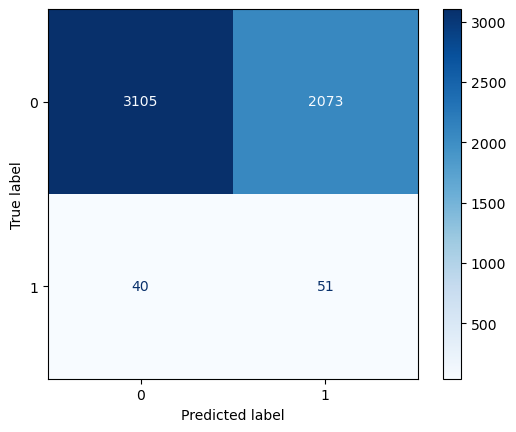

In [30]:

# Initialize XGBoost model
model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    learning_rate=0.01,
    max_depth=6,
    gamma=1,
    min_child_weight=5,
    scale_pos_weight=1
)

# Train the model
model.fit(X_train_pca, y_train_resampled)

# Predict on the test set
y_pred = model.predict(X_test_pca)
y_proba = model.predict_proba(X_test_pca)[:, 1]
cm = confusion_matrix(y_test, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualize confusion matrix as a heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="Blues")  # You can customize the color map if needed

# Evaluate the model
print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[2997 2181]
 [  39   52]]
Accuracy: 0.58
              precision    recall  f1-score   support

           0       0.99      0.58      0.73      5178
           1       0.02      0.57      0.04        91

    accuracy                           0.58      5269
   macro avg       0.51      0.58      0.39      5269
weighted avg       0.97      0.58      0.72      5269



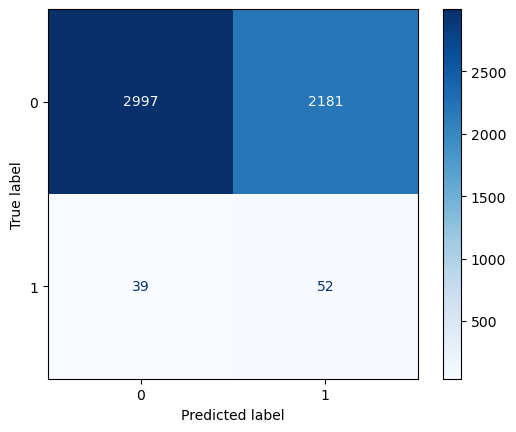

In [34]:
threshold = 0.49

# Convert probabilities to binary predictions based on the threshold
y_pred = (y_proba >= threshold).astype(int)
cm = confusion_matrix(y_test, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualize confusion matrix as a heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="Blues")  # You can customize the color map if needed

# Evaluate the model
print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
print(classification_report(y_test, y_pred))